In [ ]:
!pip install torchdiffeq


Device: cpu


Simulating trajectories: 100%|██████████| 1200/1200 [00:17<00:00, 69.05it/s] 


Training LSTM baseline (fast)...
LSTM Epoch 1/6: train_loss=0.6174 val_auc=0.6206
LSTM Epoch 2/6: train_loss=0.4743 val_auc=0.6418
LSTM Epoch 3/6: train_loss=0.4371 val_auc=0.6706
LSTM Epoch 4/6: train_loss=0.4177 val_auc=0.6934
LSTM Epoch 5/6: train_loss=0.4125 val_auc=0.7193
LSTM Epoch 6/6: train_loss=0.4034 val_auc=0.7381
LSTM test AUC: 0.7591
Training Neural ODE (fast)...
Epoch 1/12: train_loss=7.4739 val_auc=0.4415 val_mse=1.1835
Epoch 2/12: train_loss=1.7349 val_auc=0.5332 val_mse=1.0970
Epoch 3/12: train_loss=1.6278 val_auc=0.5008 val_mse=1.0664
Epoch 4/12: train_loss=1.5684 val_auc=0.4594 val_mse=1.0471
Epoch 5/12: train_loss=1.5233 val_auc=0.4591 val_mse=1.0329
Epoch 6/12: train_loss=1.4927 val_auc=0.4562 val_mse=1.0235
Epoch 7/12: train_loss=1.4720 val_auc=0.4571 val_mse=1.0162
Epoch 8/12: train_loss=1.4549 val_auc=0.4628 val_mse=1.0098
Epoch 9/12: train_loss=1.4440 val_auc=0.4152 val_mse=1.0036
Epoch 10/12: train_loss=1.4347 val_auc=0.3729 val_mse=0.9976
Epoch 11/12: train_l

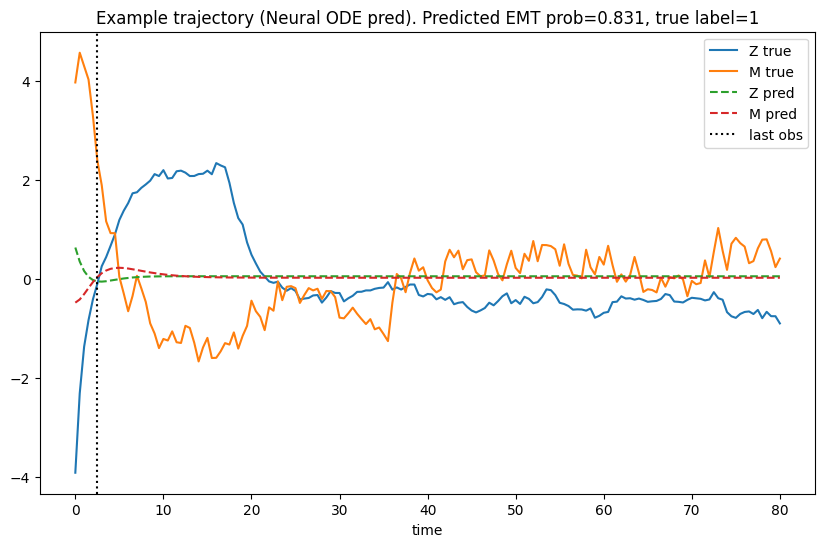

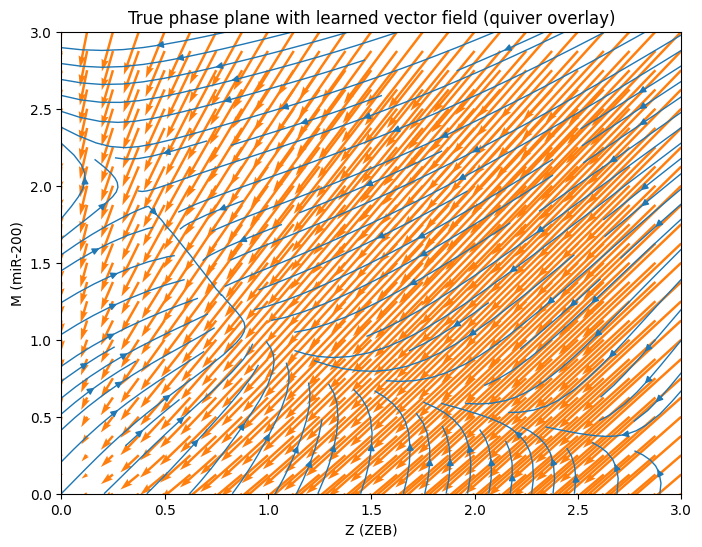

Final test AUC: Neural ODE=0.4018, LSTM baseline=0.7591
Before intervention predicted EMT prob: 0.8310459852218628
Found perturbation (L2 norm=0.0034) after 499 steps -> new prob 0.8310
Perturbation applied to last observed state (normalized units): [[ 0.00026021  0.00210147 -0.00267051]]
Done.


In [ ]:
# emt_project_fixed.py
"""
EMT Project — Neural ODE + LSTM baseline for epithelial->mesenchymal transition
Save as emt_project_fixed.py and run with: python emt_project_fixed.py

This is the corrected full script: fixes the "t must be one dimensional" error
by ensuring the time vector passed to torchdiffeq.odeint is a 1-D torch.Tensor
(on the right device) across training / evaluation / visualization calls.
"""

import os
import math
import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

# Optional: torchdiffeq (Neural ODE)
try:
    from torchdiffeq import odeint_adjoint as odeint
except Exception as e:
    raise RuntimeError("Please install torchdiffeq: pip install torchdiffeq") from e

# -----------------------------
# 1) EMT ODE Simulator
# -----------------------------
# Minimal ODE system (Z: ZEB, M: miR-200, S: external signal)
# dZ/dt = alpha_Z / (1 + (M/K_M)^n_M) + gamma_Z * S - mu_Z * Z
# dM/dt = alpha_M / (1 + (Z/K_Z)^n_Z) - mu_M * M
# dS/dt = -mu_S * S + I(t)   (I(t) is external pulse)

def emt_rhs(state, t, params, I_fun):
    Z, M, S = state
    aZ, aM, KM, KZ, nM, nZ, muZ, muM, gammaZ, muS = params
    S_in = I_fun(t)
    dZ = aZ / (1.0 + (M / KM) ** nM) + gammaZ * S - muZ * Z
    dM = aM / (1.0 + (Z / KZ) ** nZ) - muM * M
    dS = -muS * S + S_in
    return np.array([dZ, dM, dS])

def simulate_trajectory(params, x0, t_span, I_fun, noise_std=0.0):
    # Simple RK4 integrator for deterministic trajectories
    dt = t_span[1] - t_span[0]
    xs = np.zeros((len(t_span), len(x0)), dtype=float)
    xs[0] = x0
    x = x0.copy()
    for i in range(1, len(t_span)):
        t = t_span[i-1]
        k1 = emt_rhs(x, t, params, I_fun)
        k2 = emt_rhs(x + 0.5*dt*k1, t + 0.5*dt, params, I_fun)
        k3 = emt_rhs(x + 0.5*dt*k2, t + 0.5*dt, params, I_fun)
        k4 = emt_rhs(x + dt*k3, t + dt, params, I_fun)
        x = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        if noise_std > 0:
            x = x + np.random.normal(scale=noise_std, size=x.shape)
        # Ensure no negative in biologically meaningful vars
        x = np.maximum(x, 0.0)
        xs[i] = x
    return xs

# -----------------------------
# 2) Dataset generation
# -----------------------------
def sample_params(rng=np.random.RandomState(0)):
    # Reasonable parameter ranges to produce bistability in many draws
    aZ = rng.uniform(0.8, 2.0)
    aM = rng.uniform(0.8, 2.0)
    KM = rng.uniform(0.1, 1.0)
    KZ = rng.uniform(0.1, 1.0)
    nM = rng.choice([2.0, 3.0, 4.0])
    nZ = rng.choice([2.0, 3.0, 4.0])
    muZ = rng.uniform(0.1, 0.6)
    muM = rng.uniform(0.1, 0.6)
    gammaZ = rng.uniform(0.5, 2.0)
    muS = rng.uniform(0.5, 1.5)
    return (aZ, aM, KM, KZ, nM, nZ, muZ, muM, gammaZ, muS)

def sample_I_pulse(rng, t_span, amp_range=(0.0, 3.0), dur_range=(2.0, 20.0)):
    # Return a function I(t) representing a pulse starting at t0=0 lasting dur
    amp = rng.uniform(*amp_range)
    dur = rng.uniform(*dur_range)
    def I_fun(t):
        return amp if (t >= 0.0 and t <= dur) else 0.0
    return I_fun

def generate_dataset(N=2000, t_final=100.0, steps=201, rng_seed=0, noise_std=0.02):
    rng = np.random.RandomState(rng_seed)
    t_span = np.linspace(0.0, t_final, steps)
    data = []
    for i in tqdm(range(N), desc="Simulating trajectories"):
        params = sample_params(rng)
        # Random initial conditions across a plane near low values
        x0 = rng.uniform(low=0.0, high=1.0, size=3)
        I_fun = sample_I_pulse(rng, t_span, amp_range=(0.0, 3.0), dur_range=(2.0, t_final/4))
        xs = simulate_trajectory(params, x0, t_span, I_fun, noise_std=noise_std)
        # Decide label: if final Z > threshold and M small -> mesenchymal
        Z_final, M_final, S_final = xs[-1]
        label = 1 if (Z_final > 1.0 and M_final < 0.6) else 0
        data.append({
            "params": params,
            "t": t_span.astype(np.float32),
            "x": xs.astype(np.float32),   # shape [T, 3]
            "label": label,
            "x0": x0.astype(np.float32),
            "I_amp": float(I_fun(0))
        })
    return data

# -----------------------------
# 3) PyTorch datasets & dataloaders
# -----------------------------
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, items, obs_len=5, device='cpu', normalize=True):
        # items: list of dicts with "t", "x", "label"
        self.items = items
        self.obs_len = obs_len  # number of initial timepoints provided as observation
        self.device = device
        self.normalize = normalize
        # gather global statistics for normalization
        all_x = np.concatenate([it['x'] for it in items], axis=0)
        self.mean = all_x.mean(axis=0)
        self.std = all_x.std(axis=0) + 1e-6

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        x = it['x']  # [T, dim]
        t = it['t']
        label = float(it['label'])
        # Provide initial snapshot or small trajectory window as observation
        obs_x = x[:self.obs_len]  # shape [obs_len, dim]
        # For Neural ODE training, we will also provide full trajectory
        traj = x  # [T, dim]
        if self.normalize:
            obs_x = (obs_x - self.mean)/self.std
            traj = (traj - self.mean)/self.std
        # Convert to tensors on the requested device
        return {
            "obs_x": torch.tensor(obs_x, dtype=torch.float32, device=self.device),
            "traj": torch.tensor(traj, dtype=torch.float32, device=self.device),
            "t": torch.tensor(t, dtype=torch.float32, device=self.device),  # 1-D time vector
            "label": torch.tensor(label, dtype=torch.float32, device=self.device),
            "x0_raw": torch.tensor(it['x0'], dtype=torch.float32, device=self.device)
        }

# -----------------------------
# 4) Models
# -----------------------------
# Neural ODE components
class ODEF(nn.Module):
    def __init__(self, dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim)
        )
    def forward(self, t, x):
        # x: [B, dim]
        return self.net(x)

class Encoder(nn.Module):
    def __init__(self, dim, hidden=64, obs_len=5):
        super().__init__()
        self.obs_len = obs_len
        self.net = nn.Sequential(
            nn.Linear(dim*obs_len, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )
    def forward(self, obs_x):
        # obs_x: [B, obs_len, dim]
        B = obs_x.shape[0]
        x_flat = obs_x.view(B, -1)
        return self.net(x_flat)

class Classifier(nn.Module):
    def __init__(self, dim, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, feat):
        return self.net(feat).squeeze(-1)

class NeuralEMT(nn.Module):
    def __init__(self, dim=3, obs_len=5, hidden=64):
        super().__init__()
        self.encoder = Encoder(dim, hidden=hidden, obs_len=obs_len)
        self.f = ODEF(dim, hidden=hidden)
        self.classifier = Classifier(dim, hidden=hidden)
    def forward(self, obs_x, t):
        # obs_x: [B, obs_len, dim]
        # t: 1-D tensor [T]
        z0 = self.encoder(obs_x)  # [B, dim]
        # odeint expects t to be 1-D tensor and initial state shape [B, dim]
        z_traj = odeint(self.f, z0, t)  # [T, B, dim]
        z_summary = z_traj.mean(dim=0)  # average over time -> [B, dim]
        p = self.classifier(z_summary)  # [B]
        return z_traj, p

# LSTM baseline: takes the observed window and predicts P(EMT)
class LSTMBaseline(nn.Module):
    def __init__(self, dim=3, hidden=64, num_layers=1, obs_len=5):
        super().__init__()
        self.rnn = nn.LSTM(input_size=dim, hidden_size=hidden, num_layers=num_layers, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, obs_x):
        # obs_x: [B, obs_len, dim]
        out, (h, c) = self.rnn(obs_x)
        last = out[:, -1, :]  # [B, hidden]
        p = self.head(last).squeeze(-1)
        return p

# -----------------------------
# 5) Training & Evaluation Routines
# -----------------------------
def train_neural_ode(model, dataloader, val_loader, device='cpu',
                     epochs=20, lr=1e-3, lambda_traj=1.0, lambda_cls=1.0):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss()
    mse = nn.MSELoss()
    history = {"train_loss": [], "val_auc": [], "val_mse": []}
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in dataloader:
            obs_x = batch['obs_x']  # [B, obs_len, dim]
            traj = batch['traj']    # [B, T, dim]
            t = batch['t']          # t is a 1-D tensor [T]
            # ensure t is 1-D tensor on device
            if not isinstance(t, torch.Tensor):
                t = torch.tensor(t, dtype=torch.float32, device=device)
            t = t.to(device)
            label = batch['label']
            B = obs_x.shape[0]
            opt.zero_grad()
            pred_traj, p = model(obs_x, t)
            # pred_traj: [T, B, dim] -> transpose to [B, T, dim]
            pred_traj = pred_traj.permute(1, 0, 2)
            loss_traj = mse(pred_traj, traj)
            loss_cls = bce(p, label)
            loss = lambda_traj * loss_traj + lambda_cls * loss_cls
            loss.backward()
            opt.step()
            running_loss += loss.item() * B
        avg_loss = running_loss / len(dataloader.dataset)
        # validation
        val_auc, val_mse = evaluate_model(model, val_loader, device=device)
        history['train_loss'].append(avg_loss)
        history['val_auc'].append(val_auc)
        history['val_mse'].append(val_mse)
        print(f"Epoch {ep+1}/{epochs}: train_loss={avg_loss:.4f} val_auc={val_auc:.4f} val_mse={val_mse:.4f}")
    return history

def train_lstm(model, dataloader, val_loader, device='cpu', epochs=20, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss()
    history = {"train_loss": [], "val_auc": []}
    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        for batch in dataloader:
            obs_x = batch['obs_x']
            label = batch['label']
            opt.zero_grad()
            p = model(obs_x)
            loss = bce(p, label)
            loss.backward()
            opt.step()
            running_loss += loss.item() * obs_x.shape[0]
        avg_loss = running_loss / len(dataloader.dataset)
        val_auc = evaluate_lstm(model, val_loader, device=device)
        history['train_loss'].append(avg_loss)
        history['val_auc'].append(val_auc)
        print(f"LSTM Epoch {ep+1}/{epochs}: train_loss={avg_loss:.4f} val_auc={val_auc:.4f}")
    return history

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    ys = []
    ps = []
    mses = []
    with torch.no_grad():
        for batch in loader:
            obs_x = batch['obs_x']
            traj = batch['traj']
            t = batch['t']
            if not isinstance(t, torch.Tensor):
                t = torch.tensor(t, dtype=torch.float32, device=device)
            t = t.to(device)
            label = batch['label']
            pred_traj, p = model(obs_x, t)
            pred_traj = pred_traj.permute(1, 0, 2)
            # compute mse
            mse_val = ((pred_traj - traj)**2).mean().item()
            mses.append(mse_val)
            ys.append(label.cpu().numpy())
            ps.append(p.cpu().numpy())
    ys = np.concatenate(ys).ravel()
    ps = np.concatenate(ps).ravel()
    try:
        auc_score = roc_auc_score(ys, ps)
    except Exception:
        auc_score = float('nan')
    avg_mse = float(np.mean(mses))
    return auc_score, avg_mse

def evaluate_lstm(model, loader, device='cpu'):
    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for batch in loader:
            obs_x = batch['obs_x']
            label = batch['label']
            p = model(obs_x)
            ys.append(label.cpu().numpy())
            ps.append(p.cpu().numpy())
    ys = np.concatenate(ys).ravel()
    ps = np.concatenate(ps).ravel()
    try:
        auc_score = roc_auc_score(ys, ps)
    except Exception:
        auc_score = float('nan')
    return auc_score

# -----------------------------
# 6) Visualizations & vector field comparison
# -----------------------------
def plot_phase_plane(true_params, learned_f=None, xlim=(0,3), ylim=(0,3), grid_n=25):
    # Plot Z vs M phase plane with streamlines for true ODE and optionally learned vector field
    aZ, aM, KM, KZ, nM, nZ, muZ, muM, gammaZ, muS = true_params
    def true_rhs_ZM(zm, s=0.0):
        Z, M = zm
        dZ = aZ / (1.0 + (M / KM) ** nM) + gammaZ * s - muZ * Z
        dM = aM / (1.0 + (Z / KZ) ** nZ) - muM * M
        return np.array([dZ, dM])
    Zs = np.linspace(xlim[0], xlim[1], grid_n)
    Ms = np.linspace(ylim[0], ylim[1], grid_n)
    Zg, Mg = np.meshgrid(Zs, Ms)
    U = np.zeros_like(Zg)
    V = np.zeros_like(Mg)
    for i in range(grid_n):
        for j in range(grid_n):
            d = true_rhs_ZM([Zg[i,j], Mg[i,j]], s=0.0)
            U[i,j] = d[0]
            V[i,j] = d[1]
    plt.figure(figsize=(8,6))
    plt.streamplot(Zs, Ms, U.T, V.T, density=1.0, color='C0', linewidth=1)
    plt.xlabel("Z (ZEB)")
    plt.ylabel("M (miR-200)")
    plt.title("True phase plane (Z vs M) streamlines")
    if learned_f is not None:
        # overlay learned vector field as quiver (expects learned_f to take np array [N,2] and return [N,2])
        # sample grid points
        pts = np.stack([Zg.ravel(), Mg.ravel()], axis=-1)
        learned = learned_f(pts)  # [N,2]
        U_learn = learned[:,0].reshape(Zg.shape)
        V_learn = learned[:,1].reshape(Mg.shape)
        plt.quiver(Zg, Mg, U_learn, V_learn, color='C1', scale=10, width=0.004)
        plt.title("True phase plane with learned vector field (quiver overlay)")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

# Helper to extract learned vector field from ODEF (torch model)
def learned_vector_field_from_odef(odef_model, device='cpu'):
    odef_model = odef_model.to(device)
    def vf_np(xyz_nm_array):
        # xyz_nm_array: [N, 2] or [N, 3] but we only pass Z and M here (S set to 0)
        odef_model.eval()
        with torch.no_grad():
            arr = np.array(xyz_nm_array, dtype=np.float32)
            # append S=0
            if arr.shape[1] == 2:
                zeros = np.zeros((arr.shape[0],1), dtype=np.float32)
                arr3 = np.concatenate([arr, zeros], axis=1)
            else:
                arr3 = arr
            # t must be 1-D tensor for the ODEF call, but ODEF.forward ignores t value itself
            # we'll pass a dummy 1-D t vector and rely on ODEF being callable as (t, x)
            t_dummy = torch.tensor([0.0], dtype=torch.float32, device=device)
            x = torch.tensor(arr3, dtype=torch.float32, device=device)
            # ODEF expects (t, x) and returns [N, dim]
            out = odef_model(t_dummy, x).cpu().numpy()
            # return only dZ, dM
            return out[:, :2]
    return vf_np

# -----------------------------
# 7) Gradient-based minimal intervention (control)
# -----------------------------
def find_minimal_perturbation(model, obs_x, t, target_label=0, device='cpu',
                              lr=1e-2, steps=200, lambda_reg=1.0):
    """
    Given a trained model and one observed initial window obs_x [1, obs_len, dim] (already normalized),
    find small perturbation delta on the last observed state (instantaneous push) that flips the predicted label
    to target_label (0 or 1). This is a simple gradient-based approach (optimize delta to change classifier output).
    """
    model.eval()
    # We'll perturb the last observed timepoint only
    obs_x = obs_x.clone().detach().to(device)
    obs_x_pert = obs_x.clone().detach()
    delta = torch.zeros_like(obs_x_pert[:, -1, :], requires_grad=True, device=device)  # [1, dim]
    opt = optim.Adam([delta], lr=lr)
    bce = nn.BCELoss()
    target = torch.tensor([float(target_label)], dtype=torch.float32, device=device)
    # ensure t is 1-D on device
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float32, device=device)
    else:
        t = t.to(device)
    for step in range(steps):
        opt.zero_grad()
        pert_obs = obs_x_pert.clone()
        pert_obs[:, -1, :] = pert_obs[:, -1, :] + delta
        _, p = model(pert_obs, t)
        loss_cls = bce(p, target)
        loss_reg = lambda_reg * torch.norm(delta, p=2)
        loss = loss_cls + loss_reg
        loss.backward()
        opt.step()
        # early stop if flipped
        if (target_label == 0 and p.item() < 0.5) or (target_label == 1 and p.item() > 0.5):
            break
    return delta.detach().cpu().numpy(), p.item(), step

# -----------------------------
# 8) Putting it all together in main()
# -----------------------------
def collate_fn(batch):
    # Custom collate to stack tensors
    obs = torch.stack([b['obs_x'] for b in batch], dim=0)
    traj = torch.stack([b['traj'] for b in batch], dim=0)
    t = batch[0]['t']  # already a 1-D tensor on device
    labels = torch.stack([b['label'] for b in batch], dim=0)
    return {"obs_x": obs, "traj": traj, "t": t, "label": labels}

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device:", device)
    # 1) Generate dataset
    N = 1200
    data = generate_dataset(N=N, t_final=80.0, steps=161, rng_seed=1, noise_std=0.02)
    # train/val/test split
    train_items, test_items = train_test_split(data, test_size=0.2, random_state=1)
    train_items, val_items = train_test_split(train_items, test_size=0.2, random_state=2)
    # Create datasets & loaders
    obs_len = 6
    train_ds = TrajectoryDataset(train_items, obs_len=obs_len, device=device)
    val_ds = TrajectoryDataset(val_items, obs_len=obs_len, device=device, normalize=True)
    test_ds = TrajectoryDataset(test_items, obs_len=obs_len, device=device, normalize=True)
    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # 2) Baseline LSTM
    lstm = LSTMBaseline(dim=3, hidden=128, obs_len=obs_len)
    print("Training LSTM baseline (fast)...")
    train_lstm(lstm, train_loader, val_loader, device=device, epochs=6, lr=1e-3)
    test_auc_lstm = evaluate_lstm(lstm, test_loader, device=device)
    print(f"LSTM test AUC: {test_auc_lstm:.4f}")

    # 3) Neural ODE model
    model = NeuralEMT(dim=3, obs_len=obs_len, hidden=128)
    print("Training Neural ODE (fast)...")
    history = train_neural_ode(model, train_loader, val_loader, device=device,
                               epochs=12, lr=1e-3, lambda_traj=1.0, lambda_cls=1.0)
    test_auc_ode, test_mse_ode = evaluate_model(model, test_loader, device=device)
    print(f"Neural ODE test AUC: {test_auc_ode:.4f}, test traj MSE: {test_mse_ode:.6f}")

    # 4) Visualizations
    # pick a random test example and show ground truth vs predicted trajectories
    example = test_items[0]
    t = torch.tensor(example['t'], dtype=torch.float32, device=device)  # 1-D
    ds_example = TrajectoryDataset([example], obs_len=obs_len, device=device, normalize=True)
    ex = ds_example[0]
    obs_x = ex['obs_x'].unsqueeze(0)  # [1, obs_len, dim]
    traj = ex['traj'].unsqueeze(0)    # [1, T, dim]
    model.eval()
    with torch.no_grad():
        pred_traj, p = model(obs_x, t)
        pred_traj = pred_traj.permute(1,0,2).cpu().numpy()[0]  # [T, dim]
    gt = traj.cpu().numpy()[0]
    t_np = example['t']

    plt.figure(figsize=(10,6))
    plt.plot(t_np, gt[:,0], label='Z true')
    plt.plot(t_np, gt[:,1], label='M true')
    plt.plot(t_np, pred_traj[:,0], '--', label='Z pred')
    plt.plot(t_np, pred_traj[:,1], '--', label='M pred')
    plt.axvline(t_np[obs_len-1], color='k', linestyle=':', label='last obs')
    plt.legend()
    plt.xlabel("time")
    plt.title(f"Example trajectory (Neural ODE pred). Predicted EMT prob={p.item():.3f}, true label={example['label']}")
    plt.show()

    # 5) Phase plane: compare true vector field (from params of example) to learned one
    true_params = example['params']
    learned_vf = learned_vector_field_from_odef(model.f, device=device)
    plot_phase_plane(true_params, learned_f=learned_vf, xlim=(0,3), ylim=(0,3), grid_n=25)

    # 6) Test set performance detailed
    ys = []
    ps_ode = []
    ps_lstm = []
    with torch.no_grad():
        for batch in test_loader:
            obs = batch['obs_x']
            t = batch['t']
            if not isinstance(t, torch.Tensor):
                t = torch.tensor(t, dtype=torch.float32, device=device)
            t = t.to(device)
            label = batch['label'].cpu().numpy()
            _, p = model(obs, t)
            p_l = lstm(obs)
            ys.append(label)
            ps_ode.append(p.cpu().numpy())
            ps_lstm.append(p_l.cpu().numpy())
    ys = np.concatenate(ys).ravel()
    ps_ode = np.concatenate(ps_ode).ravel()
    ps_lstm = np.concatenate(ps_lstm).ravel()
    auc_ode = roc_auc_score(ys, ps_ode)
    auc_lstm = roc_auc_score(ys, ps_lstm)
    print(f"Final test AUC: Neural ODE={auc_ode:.4f}, LSTM baseline={auc_lstm:.4f}")

    # 7) Minimal intervention demo: take an example predicted to go to EMT and try to push it back
    # pick a positive example (label=1) from test set if available
    pos_example = None
    for it in test_items:
        if it['label'] == 1:
            pos_example = it
            break
    if pos_example is not None:
        ds_pos = TrajectoryDataset([pos_example], obs_len=obs_len, device=device, normalize=True)
        e = ds_pos[0]
        obs_x = e['obs_x'].unsqueeze(0)  # [1, obs_len, dim]
        t = e['t']
        # ensure t is 1-D on device
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, dtype=torch.float32, device=device)
        else:
            t = t.to(device)
        # current predicted prob
        model.eval()
        with torch.no_grad():
            _, p_before = model(obs_x, t)
        print("Before intervention predicted EMT prob:", p_before.item())
        delta, p_after, steps = find_minimal_perturbation(model, obs_x, t, target_label=0,
                                                         device=device, lr=1e-2, steps=500, lambda_reg=1.0)
        print(f"Found perturbation (L2 norm={np.linalg.norm(delta):.4f}) after {steps} steps -> new prob {p_after:.4f}")
        print("Perturbation applied to last observed state (normalized units):", delta)
    else:
        print("No positive (EMT) example in test set to demonstrate intervention.")

    print("Done.")

if __name__ == "__main__":
    main()
